# UMOD
Autosomal dominant tubulointerstitial kidney disease (ADTKD) is characterized by tubular damage and interstitial fibrosis in the absence of glomerular lesions, with inescapable progression to end-stage renal disease. ADTKD is caused by mutations in at least five different genes, including UMOD. UMOD, encoding uromodulin, which is the most abundant protein secreted in normal urine and has multiple roles in kidney physiology, including salt handling, protection against infections and kidney stones and immunomodulation. The primary effect of UMOD mutations is the endoplasmic reticulum (ER) retention of the mutant protein, probably due to protein misfolding ([Devuyst et al., 2019](https://pubmed.ncbi.nlm.nih.gov/31488840/)).

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.7.1


# UMOD
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for UMOD.

In [2]:
gene_symbol = 'UMOD'
mane_tx_id = 'NM_003361.4'
mane_protein_id = 'NP_003352.2' # Uromodulin

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.21") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Individuals Processed: 100%|██████████| 207/207 [00:00<00:00, 3407.97individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo=hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Stage 5 chronic kidney disease,HP:0003774,101
Hyperuricemia,HP:0002149,64
Elevated circulating creatinine concentration,HP:0003259,52
Hypertension,HP:0000822,44
Gout,HP:0001997,43
Chronic kidney disease,HP:0012622,42
Proteinuria,HP:0000093,35
Renal cyst,HP:0000107,32
Renal interstitial fibrosis,HP:0032948,27
Stage 1 chronic kidney disease,HP:0012623,25


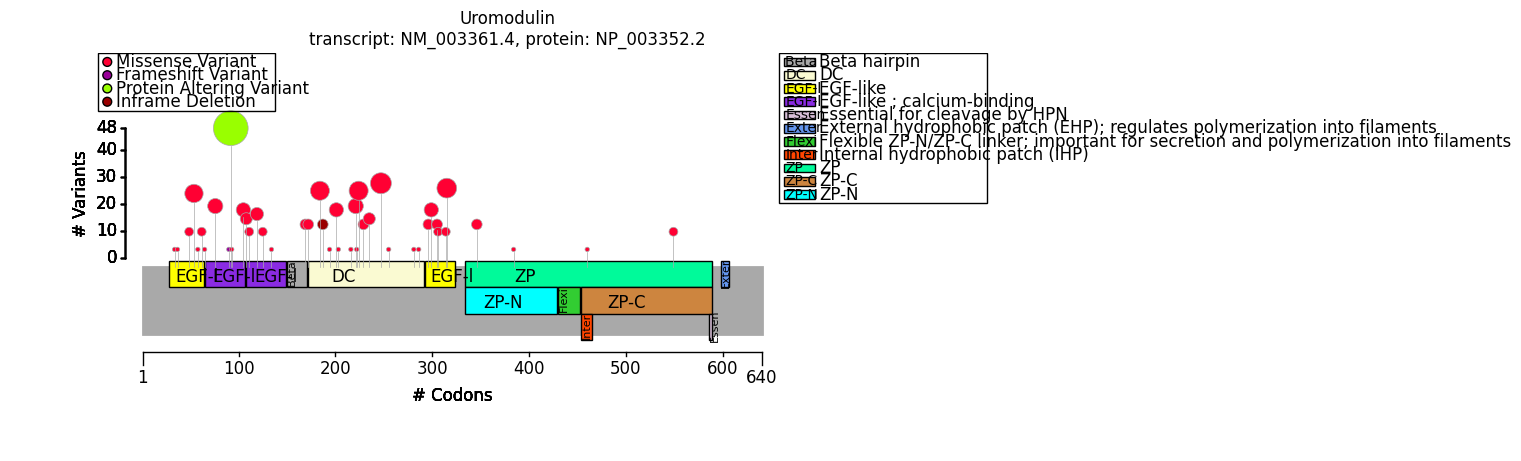

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

tgfbr1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
tgfbr1_fig.tight_layout()

# Genotype Phenotype Correlation (GPC) Analysis

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.view import CohortVariantViewer
cvv = CohortVariantViewer(tx_id=mane_tx_id)
cvv.process(cohort=cohort)

Variant key,Variant (cDNA),Variant (protein),Overlapping Exons,Effects,Count
16_20349012_20349023_CTTCGGGGCAGA_AGGAGGCGG,c.278_289delinsCCGCCTCCT,p.Val93_Gly97delinsAlaAlaSerCys,3,protein altering,42
16_20348249_20348249_T_G,c.947A>C,p.Gln316Pro,4,missense,13
16_20348557_20348557_G_C,c.744C>G,p.Cys248Trp,3,missense,12
16_20348748_20348748_G_T,c.553C>A,p.Arg185Ser,3,missense,11
16_20349138_20349138_C_T,c.163G>A,p.Gly55Ser,3,missense,11
16_20348627_20348627_G_A,c.674C>T,p.Thr225Met,3,missense,8
16_20348636_20348636_C_G,c.665G>C,p.Arg222Pro,3,missense,7
16_20348984_20348984_C_A,c.317G>T,p.Cys106Phe,3,missense,6
16_20348696_20348696_C_G,c.605G>C,p.Trp202Ser,3,missense,6
16_20349012_20349023_CTTCGGGGCAGA_AGGAGCCGG,c.278_289delinsCCGGCTCCT,p.Val93_Gly97delinsAlaGlySerCys,3,protein altering,6


In [8]:
from gpsea.view import ProteinVariantViewer
pvviewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvviewer.process(cohort=cohort)

Name,Type,Coordinates,Count,Variants
EGF-like 1,DOMAIN,28 - 64,18,p.Asn38Ile; p.Cys50Ser; p.Cys63Arg; p.Cys35Tyr; p.Asp59Ala; p.Gly55Ser
EGF-like 2; calcium-binding,DOMAIN,65 - 107,64,p.Cys77Arg; p.Cys94Arg; p.Cys92AlafsTer152; p.Val93_Gly97delinsAlaGlySerCys; p.Val93_Gly97delinsAlaAlaSerCys; p.Cys106Phe; p.Leu66Pro; p.Cys77Gly
EGF-like 3; calcium-binding,DOMAIN,108 - 149,14,p.Cys112Gly; p.Val109Glu; p.Cys112Arg; p.Cys135Gly; p.Cys120Gly; p.Cys126Arg
Beta hairpin,REGION,150 - 171,3,p.Cys170Tyr
D10C,REGION,172 - 291,72,p.Thr225Lys; p.Cys223Gly; p.Cys217Gly; p.Arg185Ser; p.Cys282Arg; p.Arg222Pro; p.Arg204Gly; p.Glu188_Leu221delinsVal; p.Pro173Arg; p.Pro236Gln; p.Arg185Leu; p.Thr225Met; p.Cys256Gly; p.Cys248Trp; p.Trp230Arg; p.Cys195Tyr; p.Thr225Arg; p.Cys248Ser; p.Trp202Ser; p.Cys287Phe
EGF-like 4,DOMAIN,292 - 323,29,p.Cys300Gly; p.Gln316Pro; p.Cys315Phe; p.Cys297Trp; p.Cys306Ser; p.Lys307Thr; p.Cys300Tyr
ZP,DOMAIN,334 - 589,7,p.Cys347Arg; p.Val550Ile; p.Arg385Trp; p.Ala461Glu; p.Cys347Gly
ZP-N,REGION,334 - 429,4,p.Arg385Trp; p.Cys347Gly; p.Cys347Arg
Flexible ZP-N/ZP-C linker; important for secretion and polymerization into filaments,REGION,430 - 453,0,
ZP-C,REGION,454 - 589,3,p.Val550Ile; p.Ala461Glu


In [9]:
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

egf1 = VariantPredicates.protein_feature(feature_id="EGF-like 1", protein_metadata=protein_meta)
egf2 = VariantPredicates.protein_feature(feature_id="EGF-like 2; calcium-binding", protein_metadata=protein_meta)
egf3 = VariantPredicates.protein_feature(feature_id="EGF-like 3; calcium-binding", protein_metadata=protein_meta)
egf = egf1 | egf2 | egf3
is_egf = monoallelic_predicate(a_predicate=egf, b_predicate=~egf, a_label="EGF", b_label="other")
egf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=is_egf,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(egf_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,5
HMF03,Skipping term because of a child term with the same individual counts,1
HMF08,Skipping general term,25
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,53


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=egf_result)

Allele group                                   EGF            other          \
                                             Count Percent    Count Percent   
Hyperuricemia [HP:0002149]                   14/32     44%    50/57     88%   
Stage 5 chronic kidney disease [HP:0003774]  52/95     55%   49/111     44%   
Gout [HP:0001997]                             8/28     29%    35/79     44%   
Chronic kidney disease [HP:0012622]          82/82    100%  106/106    100%   
Abnormal renal physiology [HP:0012211]       82/82    100%  107/107    100%   
Abnormality of the kidney [HP:0000077]       85/85    100%  109/109    100%   

Allele group                                                              
                                            Corrected p values  p values  
Hyperuricemia [HP:0002149]                            0.000106  0.000018  
Stage 5 chronic kidney disease [HP:0003774]           0.361649  0.162065  
Gout [HP:0001997]                                     0.361649  0.180824  
Chronic kidney disease [HP:0012622]                   1.000000  1.000000  
Abnormal renal physiology [HP:0012211]                1.000000  1.000000  
Abnormality of the kidney [HP:0000077]                1.000000  1.000000

In [11]:
from gpsea.analysis.temporal.endpoint import hpo_onset
term_id = "HP:0003774"  # Stage 5 chronic kidney disease
stage_5_endpoint = hpo_onset(hpo=hpo, term_id=term_id)

In [21]:
from gpsea.analysis.temporal.stats import LogRankTest
survival_statistic = LogRankTest()
from gpsea.analysis.temporal import SurvivalAnalysis
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
egf_survival_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_predicate=is_egf,
    endpoint=stage_5_endpoint,
)
print(f"p value, Stage 5 CKD, EGF domain: {egf_survival_result.pval:.4f}")

p value, Stage 5 CKD, EGF domain: 0.2844


In [22]:
delins = VariantPredicates.variant_key(key="16_20349012_20349023_CTTCGGGGCAGA_AGGAGGCGG")	# c.278_289delinsCCGCCTCCT	p.Val93_Gly97delinsAlaAlaSerCys	
is_delins = monoallelic_predicate(a_predicate=delins, b_predicate=~delins, a_label="278_289delins", b_label="other")
delins_survival_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_predicate=is_delins,
    endpoint=stage_5_endpoint,
)
print(f"p value, Stage 5 CKD, delins: {delins_survival_result.pval:.4f}")

p value, Stage 5 CKD, delins: 0.8352


In [24]:
from gpsea.analysis.predicate.genotype import sex_predicate
mf_predicate = sex_predicate()
mf_survival_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_predicate=mf_predicate,
    endpoint=stage_5_endpoint,
)
print(f"p value, Stage 5 CKD, M/F: {mf_survival_result.pval:.4f}")

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=mf_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

p value, Stage 5 CKD, M/F: 0.5344


Sex                                         FEMALE           MALE          \
                                             Count Percent  Count Percent   
Hyperuricemia [HP:0002149]                   28/42     67%  36/47     77%   
Stage 5 chronic kidney disease [HP:0003774]  39/79     49%  43/88     49%   
Chronic kidney disease [HP:0012622]          70/70    100%  79/79    100%   
Abnormal renal physiology [HP:0012211]       70/70    100%  80/80    100%   
Abnormality of the kidney [HP:0000077]       71/71    100%  84/84    100%   

Sex                                                                       
                                            Corrected p values  p values  
Hyperuricemia [HP:0002149]                                 1.0  0.349339  
Stage 5 chronic kidney disease [HP:0003774]                1.0  1.000000  
Chronic kidney disease [HP:0012622]                        1.0  1.000000  
Abnormal renal physiology [HP:0012211]                     1.0  1.000000  
Abnormality of the kidney [HP:0000077]                     1.0  1.000000

In [25]:
# all cysteine mutations in the cohort
from gpsea.analysis.predicate.genotype import VariantPredicate
from gpsea.model import Variant
class CysPredicate(VariantPredicate):

    def __init__(self, tx_id):
        super().__init__()
        self._tx_id = tx_id

    def get_question(self):
        return "missense variant affecting cysteine residue"
    
    @property
    def description(self):
        return "cysteine affecting variant"
    
    @property
    def name(self):
        return "CysPredicate"
    
    @property
    def variable_name(self):
        return "cys"
    
    def test(self, variant:Variant) -> bool:
        tx_anno = variant.get_tx_anno_by_tx_id(self._tx_id)
        return "p.Cys" in tx_anno.hgvsp

cys = CysPredicate(tx_id=mane_tx_id)
is_cys = monoallelic_predicate(a_predicate=cys, b_predicate=~cys, a_label="cysteine", b_label="other")
result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_predicate=is_cys,
    endpoint=stage_5_endpoint,
)
result.pval
cys_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=is_cys,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=cys_result)


Allele group                                cysteine            other          \
                                               Count Percent    Count Percent   
Hyperuricemia [HP:0002149]                     38/42     90%    26/47     55%   
Gout [HP:0001997]                              14/42     33%    29/65     45%   
Stage 5 chronic kidney disease [HP:0003774]    34/70     49%   67/136     49%   
Chronic kidney disease [HP:0012622]            63/63    100%  125/125    100%   
Abnormal renal physiology [HP:0012211]         63/63    100%  126/126    100%   
Abnormality of the kidney [HP:0000077]         68/68    100%  126/126    100%   

Allele group                                                              
                                            Corrected p values  p values  
Hyperuricemia [HP:0002149]                            0.001776  0.000296  
Gout [HP:0001997]                                     0.940405  0.313468  
Stage 5 chronic kidney disease [HP:0003774]           1.000000  1.000000  
Chronic kidney disease [HP:0012622]                   1.000000  1.000000  
Abnormal renal physiology [HP:0012211]                1.000000  1.000000  
Abnormality of the kidney [HP:0000077]                1.000000  1.000000

In [26]:
# p.Cys248Trp
# Let's compare Cys to non-Cys missense
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate
is_missense = VariantPredicates.variant_effect(effect=VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

non_cys_missense = is_missense & (~cys)
is_non_cys_missense = monoallelic_predicate(a_predicate=non_cys_missense, b_predicate=cys)
cys_survival_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_predicate=is_non_cys_missense,
    endpoint=stage_5_endpoint,
)
print(f"p value, Stage 5 CKD, Cysteine variant: {cys_survival_result.pval:.4f}")

p value, Stage 5 CKD, Cysteine variant: 0.1081


In [31]:
r185s = VariantPredicates.variant_key("16_20348748_20348748_G_T") # c.553C>A	p.Arg185Ser
q316p = VariantPredicates.variant_key("16_20348249_20348249_T_G") # c.947A>C	p.Gln316Pro	
c248w = VariantPredicates.variant_key("16_20348557_20348557_G_C") # c.744C>G	p.Cys248Trp	

c248w_vs_q316p = monoallelic_predicate(
    a_predicate=c248w, 
    b_predicate=q316p,
    a_label="Cys248Trp",
    b_label="Gln316Pro")
c248w_vs_q316p_survival_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_predicate=c248w_vs_q316p,
    endpoint=stage_5_endpoint,
)
print(f"p value, Stage 5 CKD, c248w vs q316p variant: {c248w_vs_q316p_survival_result.pval:.5f}")

p value, Stage 5 CKD, c248w vs q316p variant: 0.00041


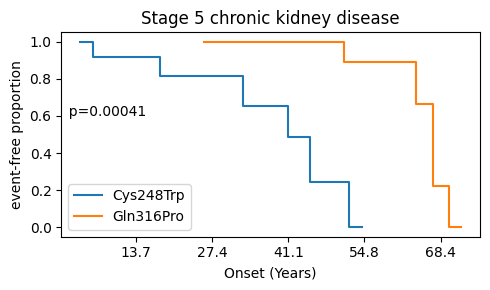

In [39]:
from matplotlib.ticker import FuncFormatter
_, ax = plt.subplots(figsize=(5, 3))
c248w_vs_q316p_survival_result.plot_kaplan_meier_curves(ax=ax)

def days_to_years(x, pos):
    return f"{x / 365.25:.1f}"


ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))

# Add labels
ax.set_xlabel("Onset (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("Stage 5 chronic kidney disease")
ax.text(x=36,y=0.6, s=f"  p={c248w_vs_q316p_survival_result.pval:.5f}")
plt.tight_layout()
plt.show()

# Summary